In [61]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as psql
import plotly.express as px


In [8]:
import os
print(f"Current working directory: {os.getcwd()}")
print(f"Directory exists: {os.path.exists('parsed csvs')}")
print(f"Is directory: {os.path.isdir('parsed csvs')}")
all_files = glob.glob(os.path.join("parsed csvs", "plays_by_*.csv"))
print(f"Number of files found: {len(all_files)}")
print(f"First few files found: {all_files[:5] if all_files else 'None'}")

Current working directory: /Users/michaelgelberg/Desktop/spring-2025
Directory exists: True
Is directory: True
Number of files found: 0
First few files found: None


In [25]:

def extract_week_from_filename(filename):
    parts = os.path.basename(filename).split("_")
    return parts[-1].replace(".csv","") #last part is the week

def extract_song_id_from_filename(filename):
    parts = os.path.basename(filename).split("_")
    return parts[-2].replace(".csv","") #second to last part is the song id

def extract_group_by_from_filename(filename):
    parts = os.path.basename(filename).split("_")
    return parts[-3].replace(".csv","") #third to last part is the group by value

def extract_measure_from_filename(filename):
    parts = os.path.basename(filename).split("_")
    return parts[0]

def extract_period_type_from_filename(filename):
    parts = os.path.basename(filename).split("_")
    return parts[1] #weekly or monthly

def load_all_csvs():
    all_files = glob.glob(os.path.join("parsed csvs", "*_by_*.csv"))
    dataframes = []
    empty_files = []
    
    for file in all_files:
        try:
            # Check if file is empty or too small
            if os.path.getsize(file) <= 1:
                print(f"Skipping empty file: {file}")
                continue
            measure = extract_measure_from_filename(file)    
            week = extract_week_from_filename(file)
            song_id = extract_song_id_from_filename(file)
            group_by = extract_group_by_from_filename(file)
            period_type = extract_period_type_from_filename(file)
            
            df = pd.read_csv(file)
            if df.empty:
                print(f"Skipping empty dataframe from: {file}")
                continue
                
            #df["week"] = week
            #df["song_id"] = song_id
            df["grouping"] = group_by
            df["period_type"] = period_type
            dataframes.append(df)
            
        except pd.errors.EmptyDataError:
            print(f"Skipping empty file: {file}")
            continue
        except Exception as e:
            print(f"Error reading file {file}: {str(e)}")
            continue
    
    if empty_files:
        with open("empty_files_to_rescrape.txt", "w") as f:
            f.write("# Run these commands to re-scrape empty files:\n")
            for song_id, week in empty_files:
                command = f"python run-export.py --force {week} {song_id}\n"
                f.write(command)
        print(f"\nEmpty files list saved to empty_files_to_rescrape.txt")

    if not dataframes:
        raise ValueError("No valid data files were found!")
        
    return pd.concat(dataframes, ignore_index=True)

# def build_velocity(df):
#     df["Week"] = pd.to_datetime(df["Week"], format="%Y%m%d")
#     df.sort_values(by=["Grouping","City","Song ID","Week"], inplace=True)

#     df["Δ Plays"] = df.groupby(["Grouping","Song ID","City"])["Current Period"].diff()
#     df["% Δ"] = df.groupby(["Grouping","Song ID","City"])["Current Period"].pct_change() * 100
#     return df
    

def main():
    df = load_all_csvs()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace('-', '_')
    )
    # df = build_velocity(df)
    df.to_csv("song_velocity_table.csv", index=False)
    print("✅ song_velocity_table.csv created with week-over-week changes")

if __name__ == "__main__":
    main()






Skipping empty file: parsed csvs/parsed_weekly_listeners_by_city_1711474234_20250124.csv
Skipping empty file: parsed csvs/parsed_weekly_listeners_by_city_1711474241_20241220.csv
Skipping empty file: parsed csvs/parsed_weekly_plays_by_city_1711474237_20240308.csv
Skipping empty file: parsed csvs/parsed_weekly_plays_by_city_1711474234_20241220.csv
Skipping empty file: parsed csvs/parsed_weekly_plays_by_city_1711474241_20250124.csv
Skipping empty file: parsed csvs/parsed_monthly_listeners_by_city_1807227249_20241201.csv
Skipping empty file: parsed csvs/parsed_weekly_listeners_by_city_1711474239_20250221.csv
Skipping empty file: parsed csvs/parsed_weekly_plays_by_city_1711474235_20241227.csv
Skipping empty file: parsed csvs/parsed_weekly_plays_by_city_1711474243_20250117.csv
Skipping empty file: parsed csvs/parsed_weekly_plays_by_city_1711474240_20250321.csv
Skipping empty file: parsed csvs/parsed_weekly_plays_by_city_1711474241_20240531.csv
Skipping empty file: parsed csvs/parsed_weekly_p

In [26]:
df = pd.read_csv('song_velocity_table.csv', parse_dates=["week"])
df[(df.city=="All Cities") & (df.measure=="listeners")].head()

,city,previous_period,current_period,%_change,week,song,song_id,measure,level,grouping,period_type
0,All Cities,23,11,-52%,2024-09-27,Artist Level,artist,listeners,artist,city,weekly
31,All Cities,7,2,-71%,2024-02-01,The Way That It Was,1711474242,listeners,song,city,monthly
44,All Cities,1,1,0%,2024-03-08,The Way That It Was,1711474242,listeners,NaN,city,weekly
48,All Cities,2,2,0%,2024-09-13,Kid,1711474235,listeners,NaN,city,weekly
51,All Cities,3,5,+67%,2024-06-01,Kid,1711474235,listeners,song,city,monthly


In [55]:
# groupings
print(df.columns)

Index(['city', 'previous_period', 'current_period', '%_change', 'week', 'song',
       'song_id', 'measure', 'level', 'grouping', 'period_type'],
      dtype='object')


In [145]:
# City-specific trend lines for each song

query = f"""
SELECT *
FROM
    (
    SELECT *, dense_rank() OVER (ORDER BY total_streams_by_city DESC) AS city_rank
    FROM 
        (
        SELECT *, SUM(total_streams)
            OVER (PARTITION BY city ROWS BETWEEN
            UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS total_streams_by_city
        FROM
            (
            SELECT
            city
            ,song
            ,week
            ,SUM(current_period) AS total_streams
            FROM df a
            WHERE 1=1
            --AND lower(a.city) like '%new york%'
            AND lower(a.measure) = 'listeners'
            AND lower(a.city) != 'all cities'
            AND lower(a.song) != 'artist level'
            GROUP BY 1, 2, 3
            )
        --ORDER BY week DESC, total_streams_by_city DESC
        )
    )
WHERE city_rank <= 5
--and city in ('New York City', 'Los Angeles', 'Chicago', 'Houston', 'Miami')
"""

result = psql.sqldf(query, locals())
result.head(25)

,city,song,week,total_streams,total_streams_by_city,city_rank
0,New York City,All In,2023-11-01 00:00:00.000000,2,430,1
1,New York City,All In,2023-11-10 00:00:00.000000,1,430,1
2,New York City,All In,2023-11-17 00:00:00.000000,0,430,1
3,New York City,All In,2023-11-24 00:00:00.000000,1,430,1
4,New York City,All In,2023-12-01 00:00:00.000000,0,430,1
5,New York City,All In,2024-01-01 00:00:00.000000,2,430,1
6,New York City,All In,2024-01-12 00:00:00.000000,1,430,1
7,New York City,All In,2024-01-19 00:00:00.000000,0,430,1
8,New York City,All In,2024-01-26 00:00:00.000000,1,430,1
9,New York City,All In,2024-02-01 00:00:00.000000,1,430,1


In [146]:
# First, get all unique dates across the entire dataset
all_dates = sorted(result['week'].unique())

# Create a complete index with all combinations of dates, songs, and cities
complete_index = pd.MultiIndex.from_product(
    [all_dates, result['song'].unique(), result['city'].unique()],
    names=['week', 'song', 'city']
)

# Reindex the dataframe to include all combinations
result_complete = result.set_index(['week', 'song', 'city']).reindex(complete_index)

# Fill NaN values with 0
result_complete['total_streams'] = result_complete['total_streams'].fillna(0)

# Reset the index to get back to a regular dataframe
result_complete = result_complete.reset_index()

In [147]:
# Find peak weeks for each city and song
peak_weeks = result_complete.groupby(['city', 'song']).apply(
    lambda x: x.loc[x['total_streams'].idxmax()]
).reset_index(drop=True)

/var/folders/28/ch6kl0w93dj_f0xxnf3gbzp00000gn/T/ipykernel_37046/3965392389.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



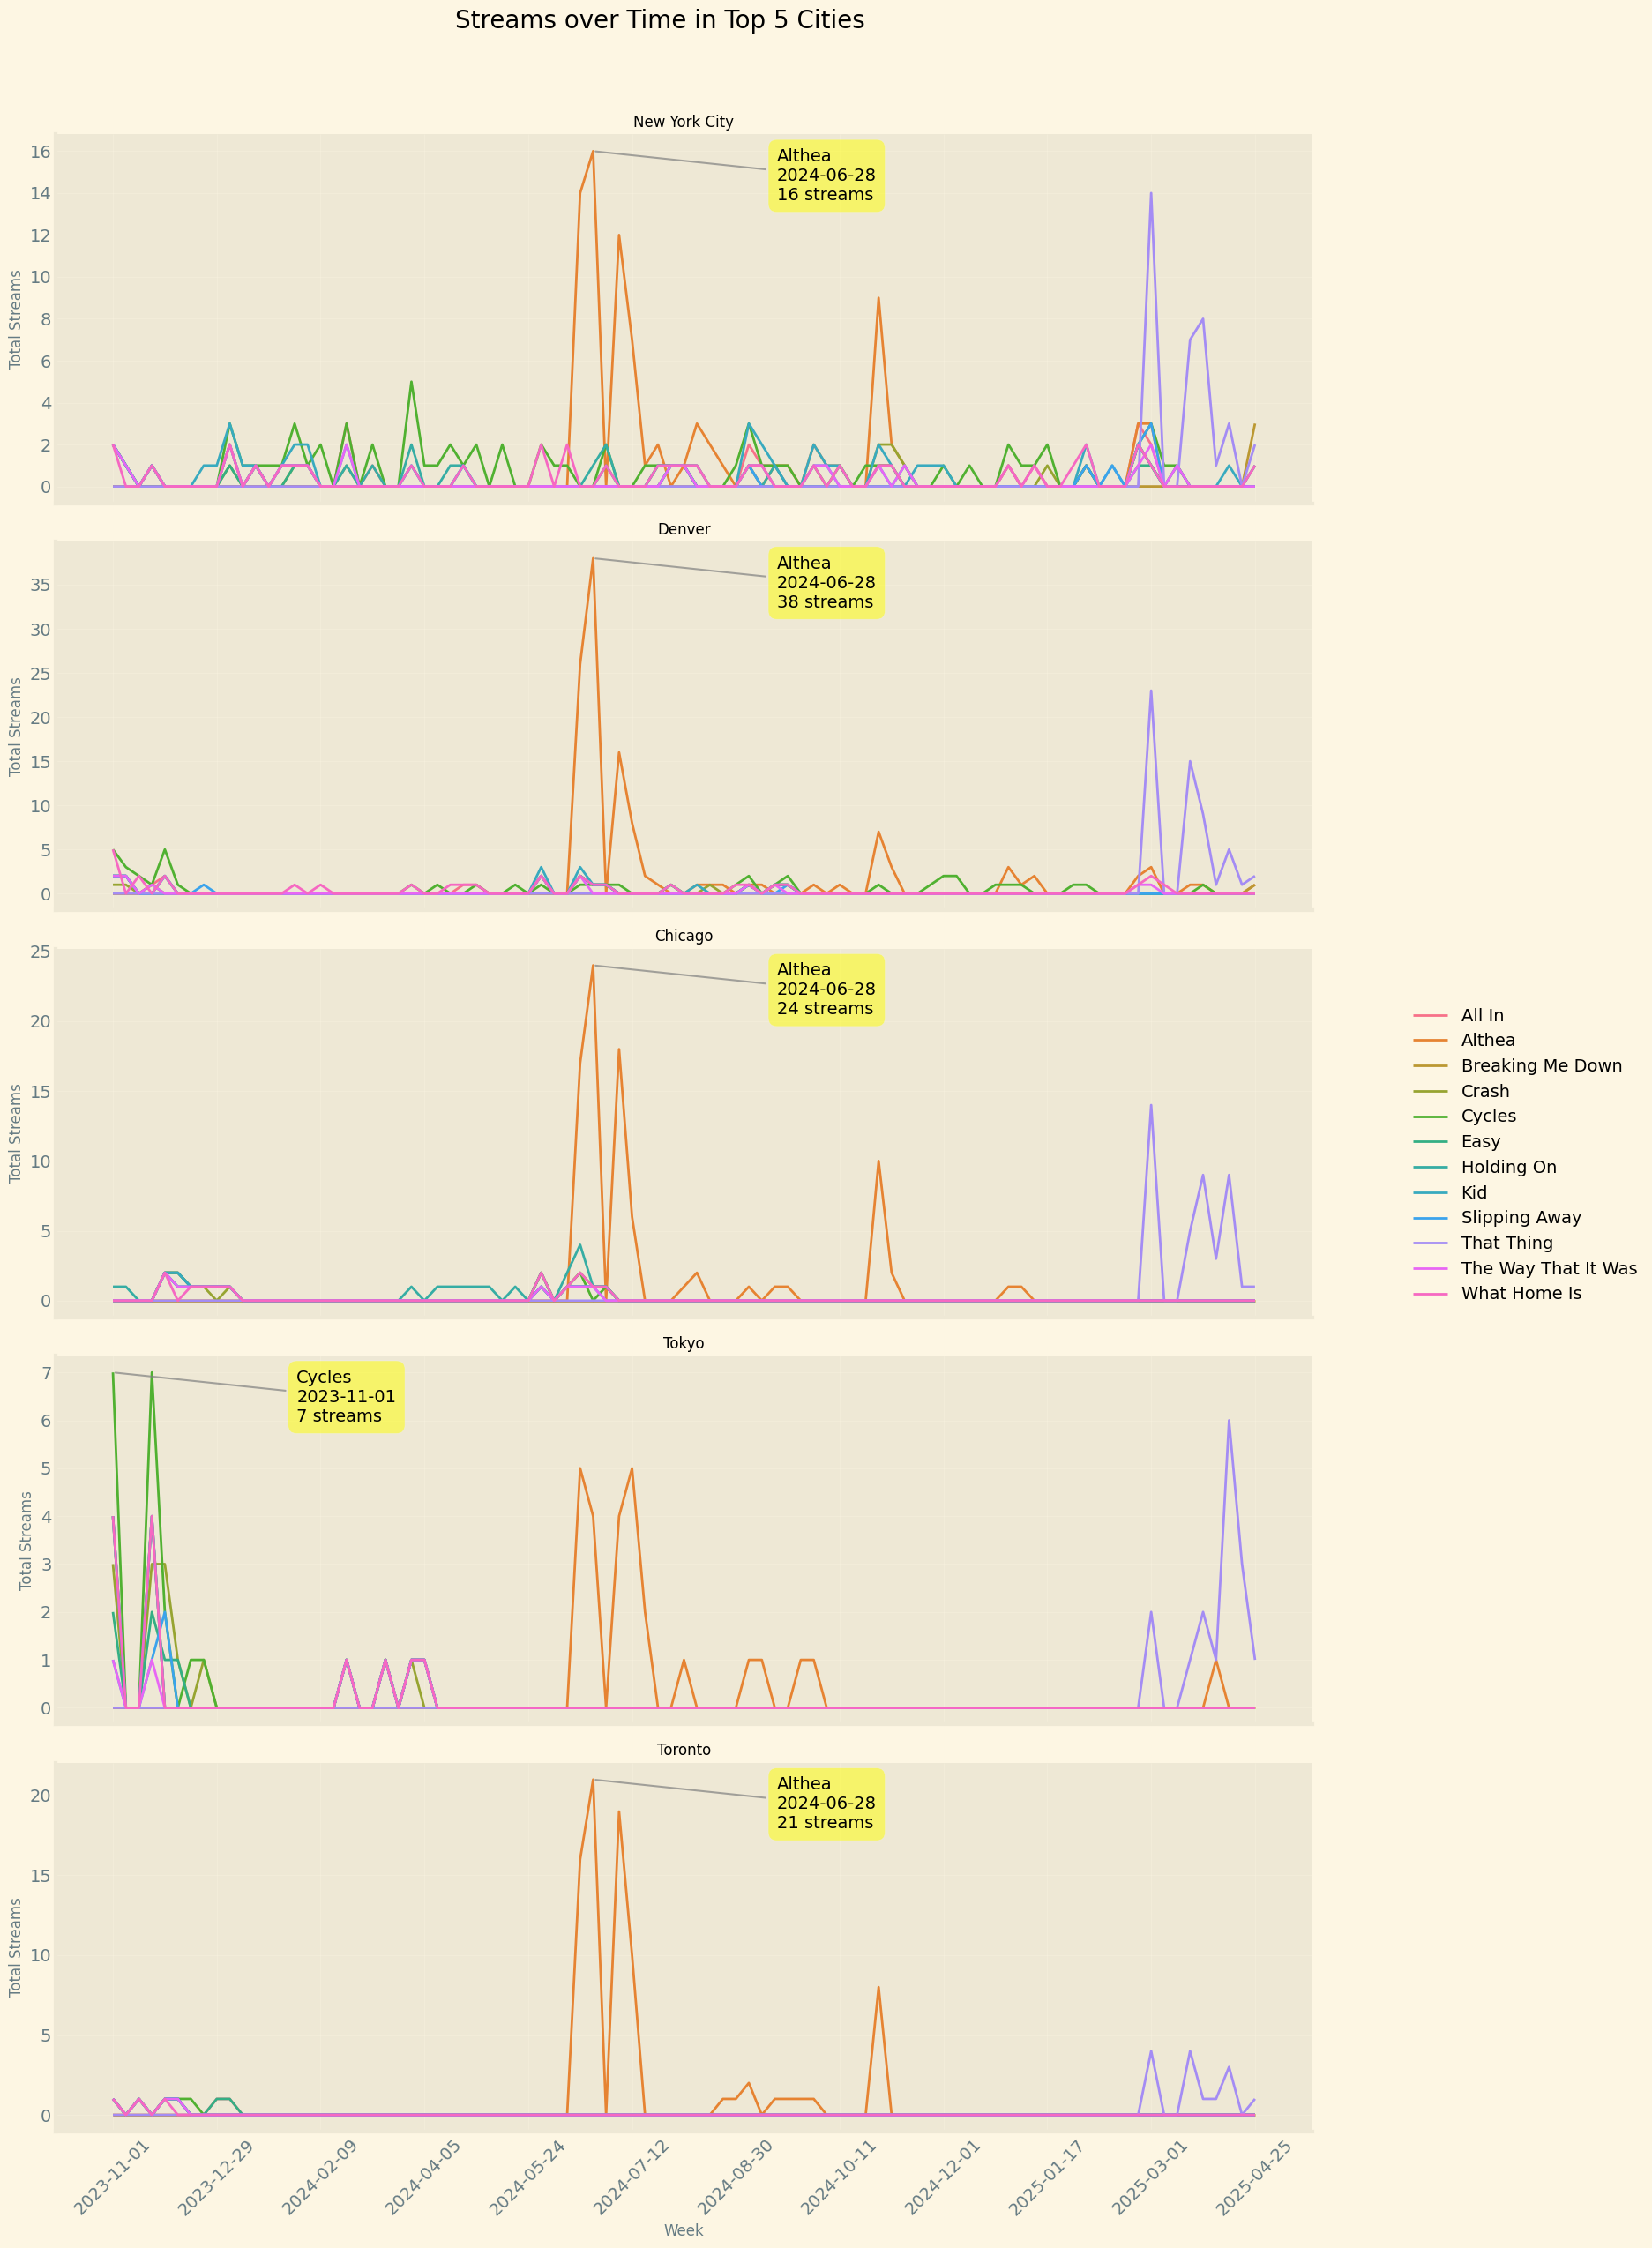

In [153]:
# Create the plot
plt.style.use('Solarize_Light2')

g = sns.FacetGrid(result_complete, 
                  col='city',
                  col_wrap=1,
                  height=5,
                  aspect=2.5,
                  sharey=False)

# Plot the data
g.map_dataframe(sns.lineplot, 
                x='week', 
                y='total_streams', 
                hue='song',
                markers=True)

g.set_axis_labels('Week', 'Total Streams')
g.set_titles('{col_name}')

#main ttitle
plt.suptitle('Streams over Time in Top 5 Cities', y=1.02, fontsize=20)

# Get unique weeks and select every 8th
unique_weeks = sorted(result_complete['week'].unique())
selected_weeks = unique_weeks[::8]

# Set x-ticks and labels for each subplot
for ax in g.axes.flat:
    # Get the city for this subplot
    city = ax.get_title()
    
    # Set x-ticks
    ax.set_xticks(selected_weeks)
    formatted_dates = [pd.to_datetime(date).strftime('%Y-%m-%d') for date in selected_weeks]
    ax.set_xticklabels(formatted_dates, rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Find the highest peak for this city
    city_peaks = peak_weeks[peak_weeks['city'] == city]
    highest_peak = city_peaks.loc[city_peaks['total_streams'].idxmax()]
    
    # Add annotation only for the highest peak, positioned to the left
    ax.annotate(
        f"{highest_peak['song']}\n{pd.to_datetime(highest_peak['week']).strftime('%Y-%m-%d')}\n{highest_peak['total_streams']:,.0f} streams",
        xy=(highest_peak['week'], highest_peak['total_streams']),
        xytext=(150, -40),  # Move annotation to the left
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(
            arrowstyle='-',  # Simple line
            color='gray',
            lw=1.5,  # Line width
            alpha=0.7
        )
    )

g.add_legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.tight_layout()
plt.show()

In [157]:
# Calculate and print summary for each city
print("\nTop Song Summary by City (first 6 weeks):")
for city in result_complete['city'].unique():
    # Get data for this city
    city_data = result_complete[result_complete['city'] == city]
    
    # Calculate average streams for each song, considering only first 6 weeks after first non-zero stream
    song_avgs = {}
    for song in city_data['song'].unique():
        song_data = city_data[city_data['song'] == song]
        # Find first non-zero stream
        non_zero_data = song_data[song_data['total_streams'] > 0]
        if len(non_zero_data) > 0:
            first_stream = non_zero_data.iloc[0]['week']
            # Get data from first stream onwards
            active_data = song_data[song_data['week'] >= first_stream]
            # Sort by week and take first 6 weeks
            first_six_weeks = active_data.sort_values('week').head(6)
            # Calculate average for first 6 weeks
            song_avgs[song] = first_six_weeks['total_streams'].mean()
        else:
            song_avgs[song] = 0
    
    # Get the top song (the tuple with the highes second value)
    top_song = max(song_avgs.items(), key=lambda x: x[1])[0]
    avg_streams = song_avgs[top_song]
    
    # Print summary with one decimal place
    print(f"{top_song} has been the top performing song in {city} averaging {avg_streams:,.1f} streams per week")


Top Song Summary by City (first 6 weeks):
Althea has been the top performing song in New York City averaging 8.3 streams per week
Althea has been the top performing song in Denver averaging 15.0 streams per week
Althea has been the top performing song in Chicago averaging 10.8 streams per week
Althea has been the top performing song in Tokyo averaging 3.3 streams per week
Althea has been the top performing song in Toronto averaging 11.0 streams per week
